# Porto Seguro's safe driver prediction

#### I) Loading and first preparation of the data

    1) Pipeline
    2) Loading Data

#### II) Exploration data analysis

    1) Unbalanced data
    2) Missing features
    3) Correlation of the features
    4) Features importance
    
#### III) Feature Engineering and Data Cleaning

    1) Feature selection and combination
    2) Imputing missing data
    3) What about other ps_reg features ?
    4) Dummification with one hot
    
#### IV) Predictive Modeling

    1) Score Metrics
    2) Algorithms
    3) Stacking & Creation of submission files
    
#### Annexe


# I) Loading and first preparation of the data

## I.1) Pipeline

In [1]:
%matplotlib inline

# Gestion des données
import numpy as np
import pandas as pd
import folium

# Visualisation
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse

# sklearn Package
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# xgboost and lightgbm
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

/Users/coraliedavid/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [ ]:
# Neural Networks
np.random.seed(10)
from tensorflow import set_random_seed
set_random_seed(15)

from keras.layers import Dense, Dropout, Embedding, Flatten, Input, merge
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Merge, Reshape, Dropout
from keras.layers.embeddings import Embedding

# Annex
from numba import jit
import time
import gc

## I.2) Loading data

In [2]:
train = pd.read_csv("./data_porto/train.csv", na_values="-1", error_bad_lines=False, sep=",")

In [3]:
test = pd.read_csv("./data_porto/test.csv", na_values="-1", error_bad_lines=False, sep=",")

We delete the duplicates of the training set.

In [4]:
train=train.drop_duplicates()

In [5]:
train.shape

(595212, 59)

# II) Exploration data analysis

## II.1) Unbalanced data

Let's see how balanced the target vector is:

In [6]:
print(sum(train['target']==1))
print(sum(train['target']==0))

21694
573518


In [7]:
data = [go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## II.2) Missing data

We use missingno to visualize the missing data.

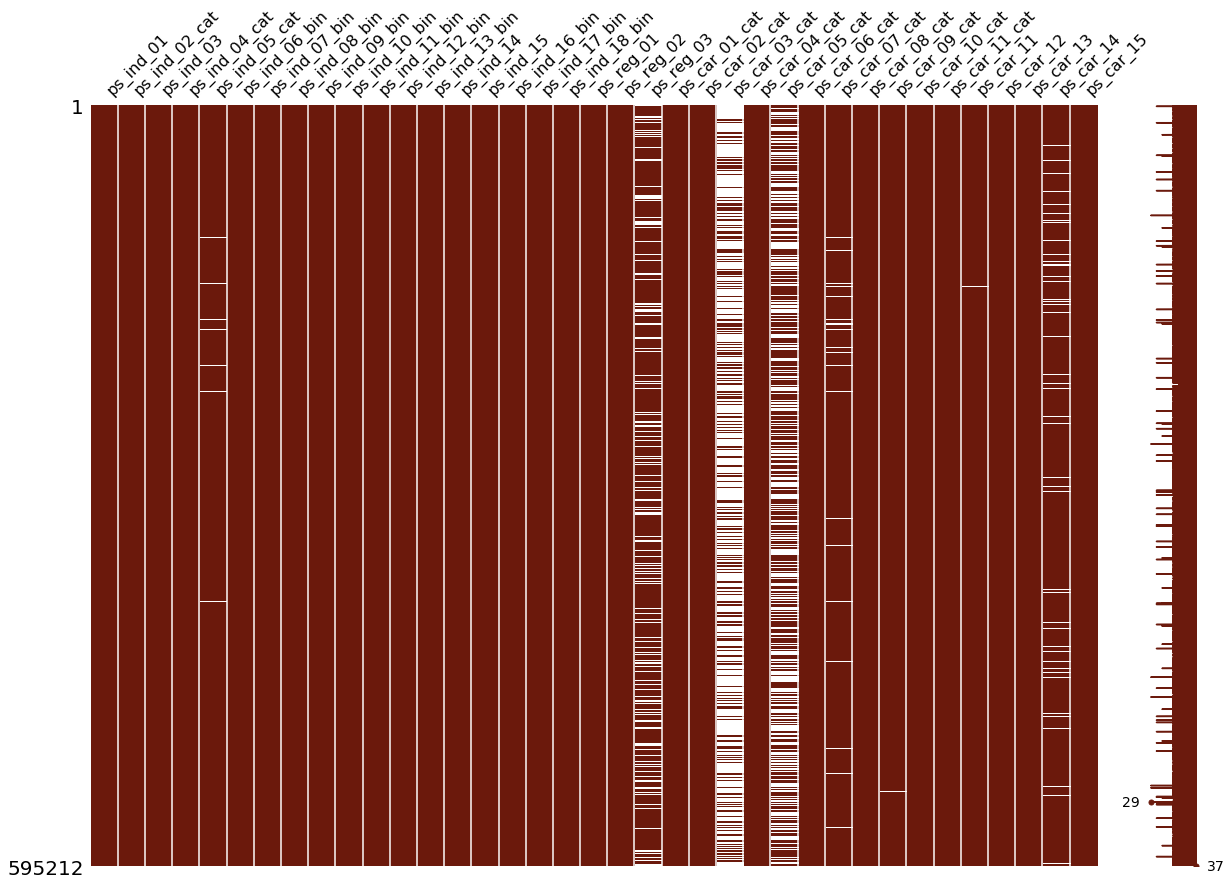

In [8]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

For the categorical features which have too much missing data, we delete them in the feature engineering section; and for other features, we fill in the missing data with the mean of the data in the feature.

## II.3) Correlation of the features

In order to check the features correlation, we separate int and float features.

#### Separation int/float

In [9]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

#### Float features

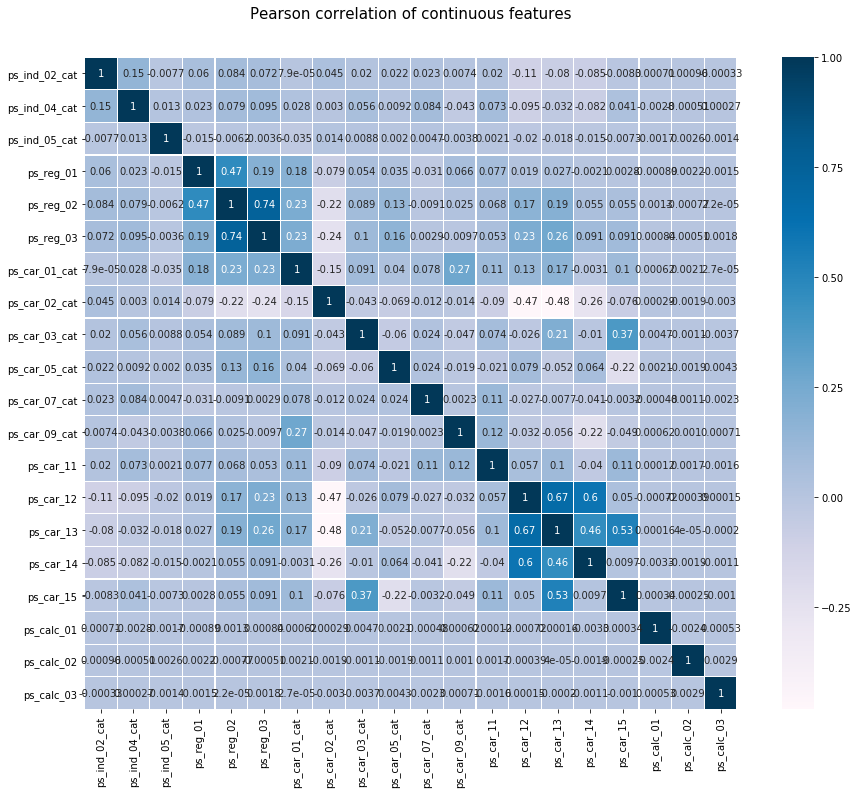

In [10]:
colormap = plt.cm.PuBu
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

#### Integer features

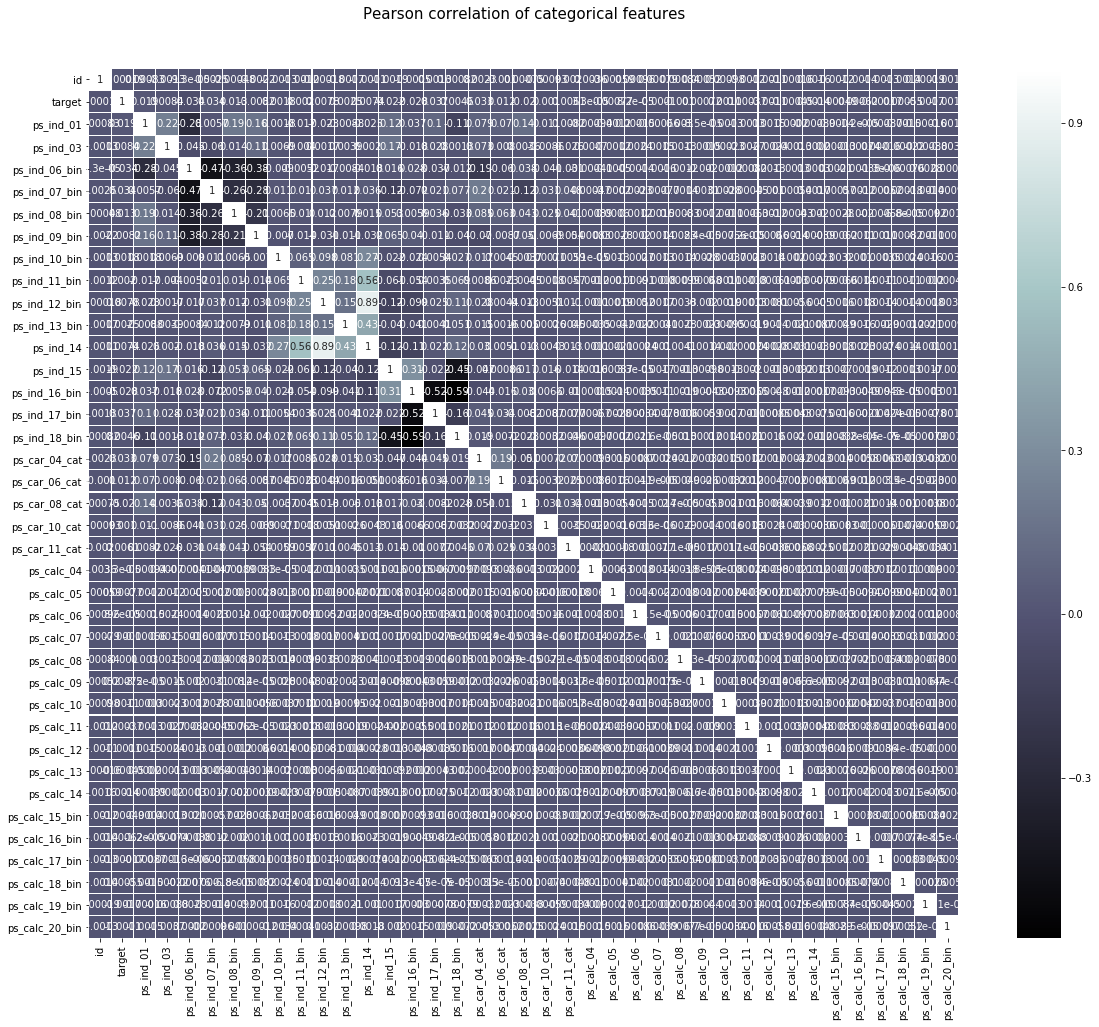

In [11]:
colormap = plt.cm.bone
plt.figure(figsize=(21,16))
plt.title('Pearson correlation of categorical features', y=1.05, size=15)
sns.heatmap(train_int.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

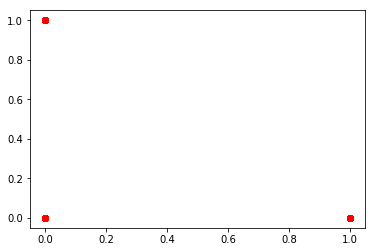

In [12]:
x1 = train["ps_ind_16_bin"][:10000].as_matrix()
x2 = train["ps_ind_18_bin"][:10000].as_matrix()


plt.plot(x1, x2, "ro")

In [13]:
train_label = train['target']
train_id = train['id']
test_id = test['id']

train = train.drop('target', axis=1)
train = train.drop('id', axis=1)
test = test.drop('id', axis = 1)

## II.4) Features importance

In [14]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'silent': 1,
    'seed' : 0
}

In [15]:
d_train = xgb.DMatrix(train, train_label, feature_names=train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), d_train, num_boost_round = 100)

In [16]:
importance = model.get_fscore()
features_df = pd.DataFrame()
features_df['feature'] = importance.keys()
features_df['fscore'] = importance.values()
features_df['fscore'] = features_df['fscore'] / features_df['fscore'].sum()
features_df.sort_values(by = ['fscore'], ascending = True, inplace = True)

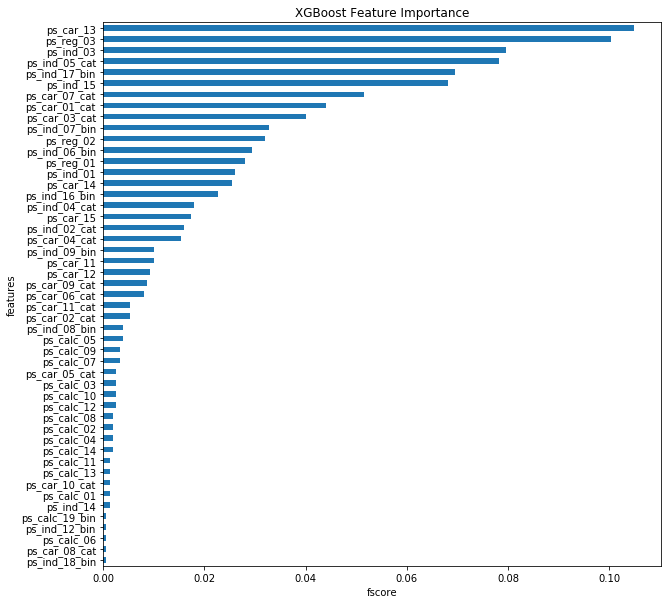

In [17]:
plt.figure()
features_df.plot(kind = 'barh', x = 'feature', y='fscore', legend = False, figsize = (10, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('fscore')
plt.ylabel('features')
plt.show()

# III) Feature Engineering and Data Cleaning

## III.1) Feature selection and combination

In [18]:
#We keep important features according to the above features importances
train_features = [ "ps_car_13", "ps_reg_03", "ps_ind_05_cat", "ps_ind_03", "ps_ind_15", "ps_reg_02", 
"ps_car_14", "ps_car_12", "ps_car_01_cat", "ps_car_07_cat", "ps_ind_17_bin", "ps_car_03_cat", "ps_reg_01",
"ps_car_15", "ps_ind_01", "ps_ind_16_bin", "ps_ind_07_bin", "ps_car_06_cat", "ps_car_04_cat", "ps_ind_06_bin",
"ps_car_09_cat", "ps_car_02_cat", "ps_ind_02_cat", "ps_car_11", "ps_car_05_cat", "ps_calc_09", "ps_calc_05", 
"ps_ind_08_bin", "ps_car_08_cat", "ps_ind_09_bin", "ps_ind_04_cat", "ps_ind_18_bin", "ps_ind_12_bin", "ps_ind_14"]

#We read in a kernel that those two pairs have matching combinations
combs = [ ('ps_reg_01', 'ps_car_02_cat'), ('ps_reg_01', 'ps_car_04_cat') ]

We append combinations of features in combs

In [19]:
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    train[name1] = train[f1].apply(lambda x: str(x)) + "_" + train[f2].apply(lambda x: str(x))
    test[name1] = test[f1].apply(lambda x: str(x)) + "_" + test[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train[name1].values) + list(test[name1].values))
    train[name1] = lbl.transform(list(train[name1].values))
    test[name1] = lbl.transform(list(test[name1].values))

    train_features.append(name1)

In [20]:
data = pd.concat([train, test], keys=['train', 'test'])

In [21]:
cat_features = [name for name in data.columns if 'cat' in name]
bin_features = [name for name in data.columns if 'bin' in name]
other_features = [name for name in data.columns if not ('bin' in name or 'cat' in name or name=='id' or name in combs)]

## III.2) Imputing missing data

New Column accounting for the number of missing data 

In [22]:
data['missing_data'] = data[data==np.NaN].sum(axis=1)

Imputing missing data: replace missing data by the mean of the column if the column represents continuous data

In [23]:
for f in other_features:
    data[f] = data[f].fillna(data[f].mean())

For the remaining columns, -1 can be an acceptable category but when too much data is missing we drop it

In [24]:
data = data.dropna(thresh=data.shape[0]/5, axis=1)
data = data.replace(np.NaN, -1)

We keep the most relevant features only

In [25]:
data = data[train_features]

## III.3) What about other ps_reg features ?

A kernel exposed the importance of reconstructing ps_reg_03, so we looked into the three reg features

In [26]:
reg_01 = train['ps_reg_01'].head(100).as_matrix() #100 different values: 137 meso-regions
reg_02 = train['ps_reg_02'].head(100).as_matrix() #19 different values: 26 states
reg_03 = train['ps_reg_03'].head(100).as_matrix() #5013 different values: 5570 municipalities

Maybe those above interpretations are the right ones. We have to reconstruct ps_reg_02

### Reconstruction of ps_reg_03

In [29]:
def recon(reg):
    integer = int(np.round((40*reg)**2)) 
    m = integer % 27 
    F = m if m else 27
    M = (integer - F)//27
    return F, M

We create two features from this single feature

In [30]:
data['ps_reg_F'] = data['ps_reg_03'].apply(lambda x: recon(x)[0])
data['ps_reg_M'] = data['ps_reg_03'].apply(lambda x: recon(x)[1])

## III.4) Dummification with one hot

Inspired from Froza and Pascal's Kernel

#### Data Separation

In [31]:
train_df = data.loc['train']
test_df = data.loc['test']

#### Implementation

In [32]:
d_median = train_df.median(axis=0)
d_mean = train_df.mean(axis=0)
d_skew = train_df.skew(axis=0)

In [33]:
one_hot = {c: list(train_df[str(c)].unique()) for c in train_df.columns if c not in ['id','target']}

In [34]:
def transform_df(df):
    df = pd.DataFrame(df)
    dcol = [c for c in df.columns if c not in ['id','target']]
    df['ps_car_13_x_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    for c in dcol:
        if '_bin' not in c: #standard arithmetic
            df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int)
            df[c+str('_mean_range')] = (df[c].values > d_mean[c]).astype(np.int)

    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < 7:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
    return df

In [35]:
train_df = transform_df(train_df)
test_df = transform_df(test_df)

In [36]:
train_df.shape

(595212, 135)

# IV) Predictive Modeling

## IV.1) Score Metrics

Gini Computation

In [37]:
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

In [38]:
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

## IV.2) Algorithms

### K-folds Cross-validation 

In [39]:
# Set up folds
K = 5
kf = sk.model_selection.KFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(0)

In [45]:
MAX_ROUNDS = 100
LEARNING_RATE = 0.09
EARLY_STOPPING_ROUNDS = 50

### Xgboost

In [46]:
model = xgb.XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

In [47]:
y_valid_pred = 0*train_label
y_test_pred = 0

In [48]:
for i, (train_index, test_index) in enumerate(kf.split(train_df)):
    
    # Create data for this fold
    y_train, y_valid = train_label.iloc[train_index].copy(), train_label.iloc[test_index]
    X_train, X_valid = train_df.iloc[train_index,:].copy(), train_df.iloc[test_index,:].copy()
    X_test = test_df.copy()
    print( "\nFold ", i)

    # Run model for this fold
    eval_set=[(X_valid,y_valid)]
    fit_model = model.fit( X_train, y_train, 
                           eval_set=eval_set,
                           eval_metric=gini_xgb,
                           early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                           verbose=False
                         )
    print( "  Best N trees = ", model.best_ntree_limit )
    print( "  Best gini = ", model.best_score )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_test, X_train, X_valid, y_train

y_test_pred /= K  # Average test set predictions

print( "\nGini for full training set:" )
eval_gini(train_label, y_valid_pred)


Fold  0
  Best N trees =  97
  Best gini =  -0.279642
  Gini =  0.279539048113

Fold  1
  Best N trees =  100
  Best gini =  -0.274774
  Gini =  0.274774431618

Fold  2
  Best N trees =  100
  Best gini =  -0.27058
  Gini =  0.2705801066

Fold  3
  Best N trees =  98
  Best gini =  -0.295226
  Gini =  0.294897387655

Fold  4
  Best N trees =  100
  Best gini =  -0.275574
  Gini =  0.275573624489

Gini for full training set:


0.27886544319305295

In [ ]:
# Create submission file
sub_xgb = pd.DataFrame()
sub_xgb['id'] = test_id
sub_xgb['target'] = y_test_pred
sub_xgb.to_csv('xgb_submit.csv', float_format='%.6f', index=False)

### Random Forest

In [ ]:
clf = RandomForestClassifier(min_samples_split = 40, max_leaf_nodes = 15, n_estimators = 450, max_depth = 6)

In [ ]:
y_valid_pred = 0*train_label
y_test_pred = 0

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(train_df)):
    
    # Create data for this fold
    y_train, y_valid = train_label.iloc[train_index].copy(), train_label.iloc[test_index]
    X_train, X_valid = train_df.iloc[train_index,:].copy(), train_df.iloc[test_index,:].copy()
    X_test = test_df.copy()
    print( "\nFold ", i)

    # Run model for this fold
    fit_model = clf.fit(X_train, y_train)
    
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_test, X_train, X_valid, y_train

y_test_pred /= K  # Average test set predictions

print( "\nGini for full training set:" )
eval_gini(train_label, y_valid_pred_1)

In [ ]:
# Create submission file
sub_rf = pd.DataFrame()
sub_rf['id'] = test_id
sub_rf['target'] = y_test_pred
sub_rf.to_csv('rf_submit.csv', float_format='%.6f', index=False)

### Light gbm

In [ ]:
# LightGBM params
lgb_params = {}
lgb_params['objective'] = 'binary'
lgb_params['boosting_type'] = 'gbdt'
lgb_params['learning_rate'] = 0.01
lgb_params['n_estimators'] = 1400 
lgb_params['max_bin'] = 255
lgb_params['num_leaves'] = 31 
lgb_params['min_child_samples'] = 1500
lgb_params['feature_fraction'] = 0.7
lgb_params['bagging_freq'] = 1
lgb_params['bagging_frac'] = 0.7
lgb_params['reg_alpha'] = 1
lgb_params['reg_lambda'] = 1

In [ ]:
lgb_model = lgb.LGBMClassifier(**lgb_params)

In [ ]:
lgb_model.fit(train_df, train_label)      

In [ ]:
y_pred = lgb_model.apply(test_df)

In [ ]:
# Create submission file
sub_lgbm = pd.DataFrame()
sub_lgbm['id'] = data.loc['test']['id']
sub_lgbm['target'] = y_pred
#sub_lgbm.to_csv('lgbm_submit.csv', float_format='%.6f', index=False)

### Neural Net

Let's reload the sets in order to do a simpler feature engineering

In [ ]:
df_train = pd.read_csv("/Users/Jenny/Desktop/Projet/train.csv")
df_test = pd.read_csv("/Users/Jenny/Desktop/Projet/test.csv")

Data loading and preprocessing

In [ ]:
X_train, y_train = df_train.iloc[:,2:], df_train.target
X_test = df_test.iloc[:,1:]

cols_use = [c for c in X_train.columns if (not c.startswith('ps_calc_'))]

X_train = X_train[cols_use]
X_test = X_test[cols_use]

In [ ]:
X_train = train_df
y_train = train_label
X_test = test_df

In [ ]:
col_vals_dict = {c: list(X_train[c].unique()) for c in X_train.columns if c.endswith('_cat')}

In [ ]:
embed_cols = []
for c in col_vals_dict:
    if len(col_vals_dict[c])>2:
        embed_cols.append(c)
        print(c + ': %d values' % len(col_vals_dict[c])) #look at value counts to know the embedding dimensions

print('\n')

In [ ]:
def build_embedding_network():
    
    models = []
    
    model_ps_ind_02_cat = Sequential()
    model_ps_ind_02_cat.add(Embedding(8, 3, input_length=1))
    model_ps_ind_02_cat.add(Reshape(target_shape=(3,)))
    models.append(model_ps_ind_02_cat)
    
    model_ps_ind_04_cat = Sequential()
    model_ps_ind_04_cat.add(Embedding(13, 2, input_length=1))
    model_ps_ind_04_cat.add(Reshape(target_shape=(2,)))
    models.append(model_ps_ind_04_cat)
    
    model_ps_ind_05_cat = Sequential()
    model_ps_ind_05_cat.add(Embedding(3, 5, input_length=1))
    model_ps_ind_05_cat.add(Reshape(target_shape=(5,)))
    models.append(model_ps_ind_05_cat)
    
    model_ps_car_01_cat = Sequential()
    model_ps_car_01_cat.add(Embedding(3, 7, input_length=1))
    model_ps_car_01_cat.add(Reshape(target_shape=(7,)))
    models.append(model_ps_car_01_cat)
    
    model_ps_car_02_cat = Sequential()
    model_ps_car_02_cat.add(Embedding(18, 2, input_length=1))
    model_ps_car_02_cat.add(Reshape(target_shape=(2,)))
    models.append(model_ps_car_02_cat)
    
    model_ps_car_03_cat = Sequential()
    model_ps_car_03_cat.add(Embedding(10, 2, input_length=1))
    model_ps_car_03_cat.add(Reshape(target_shape=(2,)))
    models.append(model_ps_car_03_cat)
    
    model_ps_car_04_cat = Sequential()
    model_ps_car_04_cat.add(Embedding(6, 5, input_length=1))
    model_ps_car_04_cat.add(Reshape(target_shape=(5,)))
    models.append(model_ps_car_04_cat)
    
    model_ps_car_05_cat = Sequential()
    model_ps_car_05_cat.add(Embedding(3, 2, input_length=1))
    model_ps_car_05_cat.add(Reshape(target_shape=(2,)))
    models.append(model_ps_car_05_cat)
    
    model_ps_car_06_cat = Sequential()
    model_ps_car_06_cat.add(Embedding(5, 8, input_length=1))
    model_ps_car_06_cat.add(Reshape(target_shape=(8,)))
    models.append(model_ps_car_06_cat)
    
    model_ps_car_07_cat = Sequential()
    model_ps_car_07_cat.add(Embedding(3, 2, input_length=1))
    model_ps_car_07_cat.add(Reshape(target_shape=(2,)))
    models.append(model_ps_car_07_cat)
    
    model_ps_car_09_cat = Sequential()
    model_ps_car_09_cat.add(Embedding(3, 3, input_length=1))
    model_ps_car_09_cat.add(Reshape(target_shape=(3,)))
    models.append(model_ps_car_09_cat)
    
    model_ps_car_10_cat = Sequential()
    model_ps_car_10_cat.add(Embedding(24, 2, input_length=1))
    model_ps_car_10_cat.add(Reshape(target_shape=(2,)))
    models.append(model_ps_car_10_cat)
    
    model_ps_car_11_cat = Sequential()
    model_ps_car_11_cat.add(Embedding(100, 10, input_length=1))
    model_ps_car_11_cat.add(Reshape(target_shape=(10,)))
    models.append(model_ps_car_11_cat)
    
    model_rest = Sequential()
    model_rest.add(Dense(16, input_dim=24))
    models.append(model_rest)

    model = Sequential()
    model.add(Merge(models, mode='concat'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dropout(.35))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dropout(.15))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(.15))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [ ]:
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = (X_train[c]).unique()
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i  
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test

In [ ]:
#gini scoring function from kernel at: 
#https://www.kaggle.com/tezdhar/faster-gini-calculation
def ginic(actual, pred):
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_c[-1] - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    return ginic(a, p) / ginic(a, a)

In [ ]:
#network training
K = 5
runs_per_fold = 3
n_epochs = 76

cv_ginis = []
full_val_preds = np.zeros(np.shape(X_train)[0])
y_preds = np.zeros((np.shape(X_test)[0],K))

kfold = StratifiedKFold(n_splits = K, 
                            random_state = 231, 
                            shuffle = True)    

In [ ]:
for i, (f_ind, outf_ind) in enumerate(kfold.split(X_train, y_train)):

    X_train_f, X_val_f = X_train.loc[f_ind].copy(), X_train.loc[outf_ind].copy()
    y_train_f, y_val_f = y_train[f_ind], y_train[outf_ind]
    
    X_test_f = X_test.copy()
    
    pos = (pd.Series(y_train_f == 1))
    print( "\nFold ", i)
    
    # Add positive examples
    X_train_f = pd.concat([X_train_f, X_train_f.loc[pos]], axis=0)
    y_train_f = pd.concat([y_train_f, y_train_f.loc[pos]], axis=0)
    
    # Shuffle data
    idx = np.arange(len(X_train_f))
    np.random.shuffle(idx)
    X_train_f = X_train_f.iloc[idx]
    y_train_f = y_train_f.iloc[idx]
    
    #preprocessing
    proc_X_train_f, proc_X_val_f, proc_X_test_f = preproc(X_train_f, X_val_f, X_test_f)
    
    #track oof prediction for cv scores
    val_preds = 0
    
    for j in range(runs_per_fold):
    
        NN = build_embedding_network()
        NN.fit(proc_X_train_f, y_train_f.values, epochs=n_epochs, batch_size=4096, verbose=0)
   
        val_preds += NN.predict(proc_X_val_f)[:,0] / runs_per_fold
        y_preds[:,i] += NN.predict(proc_X_test_f)[:,0] / runs_per_fold
        
    full_val_preds[outf_ind] += val_preds
        
    cv_gini = eval_gini(y_val_f.values, val_preds)
    cv_ginis.append(cv_gini)
    print( "  Gini = ", cv_gini )

print('Mean out of fold gini: %.5f' % np.mean(cv_ginis))
print('Full validation gini: %.5f' % eval_gini(y_train.values, full_val_preds))

y_pred_final = np.mean(y_preds, axis=1)

In [ ]:
# Create submission file
sub_NN = pd.DataFrame()
sub_NN['id'] = test_id
sub_NN['target'] = y_pred_final
sub_NN.to_csv('NN_submit.csv', float_format='%.6f', index=False)

## IV.4) Stacking & Creation of submission files

### Linear Stacking

In [ ]:
sub_lin = pd.DataFrame()
sub_lin['id'] = sub_xgb['id']
sub_lin['target'] = 0.25 * ( sub_NN['target'] + sub_lgbm['target'] + sub_rf['target'] + sub_xgb['target'])

sub_lin.to_csv('sub_lin.csv', index = False, float_format='%.6f') 

### Log Stacking

In [ ]:
sub_log = pd.DataFrame()
sub_log['id'] = sub_xgb['id']
sub_log['target'] = np.exp(np.mean(
    [
    sub_NN['target'].apply(lambda x: np.log(x)),\
#    sub_lgbm['target'].apply(lambda x: np.log(x)),\
    sub_rf['target'].apply(lambda x: np.log(x)),\
    sub_xgb['target'].apply(lambda x: np.log(x)),\
    ], axis =0))

sub_log.to_csv('sub.csv', index = False, float_format='%.6f') 

# Annexe

### From now on, we did not use any of the following algorithms in our final submission, because the result was not as good as the other results, but we left it in the code for you to see our work process

### SVM

In [ ]:
from sklearn import svm

In [ ]:
y_valid_pred = 0*y
y_test_pred = 0

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(train_df)):
    
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test_df.copy()
    print( "\nFold ", i)
    
    clf = svm.SVC(C=1e15, max_iter=400, kernel = 'poly')
    clf.fit(X_train, y_train)
    
    pred = clf.predict(X_valid)
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    del X_test, X_train, X_valid, y_train

print( "\nGini for full training set:" )
eval_gini(y, y_valid_pred)

### PCA

In [ ]:
from sklearn.decomposition import PCA

X = train
pca = PCA(n_components=2)
pca.fit(X)

In [ ]:
X2D = pca.transform(X)

In [ ]:
X2D_pos = []
X2D_neg = []
for i in range(len(X2D)):
    if y[i]:
        X2D_pos.append(X2D[i])
    else:
        X2D_neg.append(X2D[i])
X2D_pos = np.array(X2D_pos)
X2D_neg = np.array(X2D_neg)

In [ ]:
plt.plot(X2D_pos.T[0], X2D_pos.T[1], 'bo')
plt.plot(X2D_neg.T[0], X2D_neg.T[1], 'ro')

In [ ]:
#for i in range(len(X2D)):
#    if i%1000==0: print(i)
#    if y[i] == 1:
#        couleur = 'bx'
#    else:
#        couleur = 'ro'
#    plt.plot(X2D[i][0], X2D[i][1], couleur)
#plt.show()

In [ ]:
from sklearn.decomposition import PCA

X = train
pca = PCA(n_components=3)
pca.fit(X)

In [ ]:
X3D = pca.transform(X)

In [ ]:
X3D_sub = X3D[:10000]

In [ ]:
X3D_pos = []
X3D_neg = []
for i in range(len(X3D_sub)):
    if y[i]:
        X3D_pos.append(X3D_sub[i])
    else:
        X3D_neg.append(X3D_sub[i])
X3D_pos = np.array(X3D_pos)
X3D_neg = np.array(X3D_neg)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot(X3D_pos.T[0], X3D_pos.T[1], X3D_pos.T[2], 'bo', alpha = 1)
ax.plot(X3D_neg.T[0], X3D_neg.T[1], X3D_neg.T[2], 'ro', alpha = 0.5)

In [ ]:
from sklearn.cluster import k_means

k_m = k_means(X, 2)

In [ ]:
k_means.predict()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

In [ ]:
clf = LR(tol=0.0001, C=1e15, class_weight='balanced', random_state=None, solver='sag', max_iter=100000)
clf = clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
len(y_test)

In [ ]:
sum(y_pred == y_test)

In [ ]:
F1 = sk.metrics.f1_score(y_test, y_pred)
F1